In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
custom_palette = sns.color_palette("tab10", n_colors=2)

In [4]:
data_path = "./jade_apex_filtered.csv"

In [19]:
data_df = pd.read_csv(data_path)
data_df.groupby(["env", "exp", "size"]).count().reset_index()

,env,exp,size,episode_reward_max,episode_reward_min,episode_reward_mean,episodes_this_iter,num_env_steps_sampled,num_env_steps_trained,num_agent_steps_sampled,...,learner_grad_time_ms,learner_grad_throughput,learner_overall_time_ms,learner_overall_throughput,target_net_update_time_ms,episodes_total,training_iteration,time_this_iter_s,time_total_s,buffer
0,BeamRider,APEX_DDQN_BeamRiderNoFrameskip-v4_DPBER_512745,8,9998,9998,9998,9999,9999,9999,9999,...,9998,9998,9998,9998,9998,9999,9999,9999,9999,9999
1,BeamRider,APEX_DDQN_BeamRiderNoFrameskip-v4_DPBER_514027,16,8612,8612,8612,8615,8615,8615,8615,...,8614,8614,8614,8614,8614,8615,8615,8615,8615,8615
2,BeamRider,APEX_DDQN_BeamRiderNoFrameskip-v4_DPBER_514031,32,4257,4257,4257,4258,4258,4258,4258,...,4257,4257,4257,4257,4256,4258,4258,4258,4258,4258
3,BeamRider,APEX_DDQN_BeamRiderNoFrameskip-v4_DPER_512749,1,9998,9998,9998,9999,9999,9999,9999,...,9998,9998,9998,9998,9996,9999,9999,9999,9999,9999
4,Breakout,APEX_DDQN_BreakoutNoFrameskip-v4_DPBER_512748,8,9999,9999,9999,9999,9999,9999,9999,...,9998,9998,9998,9998,9997,9999,9999,9999,9999,9999
5,Breakout,APEX_DDQN_BreakoutNoFrameskip-v4_DPBER_514026,32,4592,4592,4592,4592,4592,4592,4592,...,4591,4590,4591,4590,4590,4592,4592,4592,4592,4592
6,Breakout,APEX_DDQN_BreakoutNoFrameskip-v4_DPBER_514029,16,8281,8281,8281,8281,8281,8281,8281,...,8280,8280,8280,8280,8279,8281,8281,8281,8281,8281
7,Breakout,APEX_DDQN_BreakoutNoFrameskip-v4_DPER_512746,1,9999,9999,9999,9999,9999,9999,9999,...,9998,9997,9998,9997,9995,9999,9999,9999,9999,9999
8,Centipede,APEX_DDQN_CentipedeNoFrameskip-v4_DPER_516176,1,9999,9999,9999,9999,9999,9999,9999,...,9998,9998,9998,9998,9996,9999,9999,9999,9999,9999
9,ChopperCommand,APEX_DDQN_ChopperCommandNoFrameskip-v4_DPBER_5...,32,4626,4626,4626,4626,4626,4626,4626,...,4625,4625,4625,4625,4625,4626,4626,4626,4626,4626


In [38]:
data_df = pd.read_csv(data_path)
data_df = data_df[data_df["env"].isin(["BeamRider", "Breakout", "Qbert", "SpaceInvaders"])]
data_df = data_df[data_df["size"].isin([1, 32])]
data_df = data_df[data_df["num_env_steps_trained"] >= 100000]
data_df["steps"] = data_df["num_env_steps_trained"] * 4
window_size = 50000

# 2. Define helper functions

def compute_interval_mean_with_steps(env_data):
    env_name = env_data['env'].iloc[0]
    bins = list(np.arange(0, env_data["steps"].max() + window_size, window_size))
    env_data["steps_interval"] = pd.cut(env_data["steps"], bins, labels=bins[:-1], right=False)
    numeric_cols = env_data.select_dtypes(include=[np.number]).columns.tolist()
    interval_data = env_data.groupby('steps_interval')[numeric_cols].mean().reset_index()
    interval_data['env'] = env_name
    return interval_data

def compute_T_save_for_steps(env_name, data1, data2):
    rewards1 = data1[data1['env'] == env_name]['episode_reward_mean'].values
    rewards2 = data2[data2['env'] == env_name]['episode_reward_mean'].values
    steps1 = data1[data1['env'] == env_name]['steps'].values
    steps2 = data2[data2['env'] == env_name]['steps'].values
    steps_diff_ratios = []
    max_reward = max(rewards1.max(), rewards2.max())
    reward_samples = np.linspace(0, max_reward, 51)
    for target_reward in reward_samples:
        step1 = next((steps1[i] for i, r in enumerate(rewards1) if r >= target_reward), None)
        step2 = next((steps2[i] for i, r in enumerate(rewards2) if r >= target_reward), None)
        if step1 is not None and step2 is not None:
            steps_diff_ratio = (step1 - step2) / step1
            steps_diff_ratios.append(steps_diff_ratio)
    return np.median(steps_diff_ratios) if steps_diff_ratios else None

def compute_improvement_per_pber(env_name, data_per, data_pber, n):
    # Get last n steps from PER
    last_steps_per = data_per[data_per['env'] == env_name]['steps'].tail(n).values
    
    # Get rewards from PBER at the same steps
    pber_rewards_at_same_steps = []
    for step in last_steps_per:
        closest_pber_row = data_pber[data_pber['env'] == env_name].iloc[(data_pber[data_pber['env'] == env_name]['steps'] - step).abs().argsort()[:1]]
        if not closest_pber_row.empty:
            pber_rewards_at_same_steps.append(closest_pber_row['episode_reward_mean'].values[0])
    
    avg_per_reward = data_per[data_per['env'] == env_name]['episode_reward_mean'].tail(n).mean()
    avg_pber_reward_at_same_steps = np.mean(pber_rewards_at_same_steps)
    
    improvement_percentage_per_pber = ((avg_pber_reward_at_same_steps - avg_per_reward) / avg_per_reward)  if avg_per_reward != 0 else np.nan
    
    return improvement_percentage_per_pber


# 3. Main data processing and analysis steps with adjusted alignment

data_df_sorted = data_df.sort_values(by=["env", "steps"])
per_data_sorted = data_df_sorted[data_df_sorted['buffer'] == 'DPER']
pber_data_sorted = data_df_sorted[data_df_sorted['buffer'] == 'DPBER']

per_interval_data_sorted = pd.concat([compute_interval_mean_with_steps(per_data_sorted[per_data_sorted['env'] == env]) for env in per_data_sorted['env'].unique()])
pber_interval_data_sorted = pd.concat([compute_interval_mean_with_steps(pber_data_sorted[pber_data_sorted['env'] == env]) for env in pber_data_sorted['env'].unique()])

# Compute metrics for ER vs. BER and PER vs. PBER using sorted data
results_sorted = []
for env in data_df_sorted['env'].unique():
    R_improve_per_pber = (pber_interval_data_sorted[pber_interval_data_sorted['env'] == env]["episode_reward_mean"].median() - per_interval_data_sorted[per_interval_data_sorted['env'] == env]["episode_reward_mean"].median()) / pber_interval_data_sorted[pber_interval_data_sorted['env'] == env]["episode_reward_mean"].median()

    try:
        T_save_per_pber = compute_T_save_for_steps(env, per_data_sorted, pber_data_sorted)
        avg_per_reward, avg_pber_reward = compute_avg_reward_last_episodes(env, per_data_sorted, pber_data_sorted, n)
        improvement_percentage_per_pber_adj = compute_improvement_per_pber(env, per_data_sorted, pber_data_sorted, n)
        
        results_sorted.append({
            'Environment': env,
            'R_improve_DPER_DPBER': R_improve_per_pber,
            'T_save_DPER_DPBER': T_save_per_pber,
            'Improvement_DPER_DPBER': improvement_percentage_per_pber_adj
        })
    except:
        pass
result_df_sorted_steps_adj = pd.DataFrame(results_sorted).set_index('Environment')
mean_values_sorted_steps_adj = result_df_sorted_steps_adj.mean(axis=0, skipna=True)
mean_values_sorted_steps_adj.name = "Mean"
result_df_sorted_steps_adj = pd.concat([result_df_sorted_steps_adj, pd.DataFrame(mean_values_sorted_steps_adj).T])

result_df_sorted_steps_adj

/tmp/ipykernel_19397/3253872709.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data["steps_interval"] = pd.cut(env_data["steps"], bins, labels=bins[:-1], right=False)
/tmp/ipykernel_19397/3253872709.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data["steps_interval"] = pd.cut(env_data["steps"], bins, labels=bins[:-1], right=False)
/tmp/ipykernel_19397/3253872709.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,R_improve_DPER_DPBER,T_save_DPER_DPBER,Improvement_DPER_DPBER
BeamRider,0.749751,0.000072,0.636315
Breakout,0.707434,0.085566,0.150503
Qbert,0.610656,-0.624524,-0.178756
SpaceInvaders,0.686611,-1.347873,-0.072563
Mean,0.688613,-0.471690,0.133875


/tmp/ipykernel_19397/1289283208.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = (data["time(h)"] // window_size) * window_size
/tmp/ipykernel_19397/1289283208.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = (data["time(h)"] // window_size) * window_size
/tmp/ipykernel_19397/1289283208.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

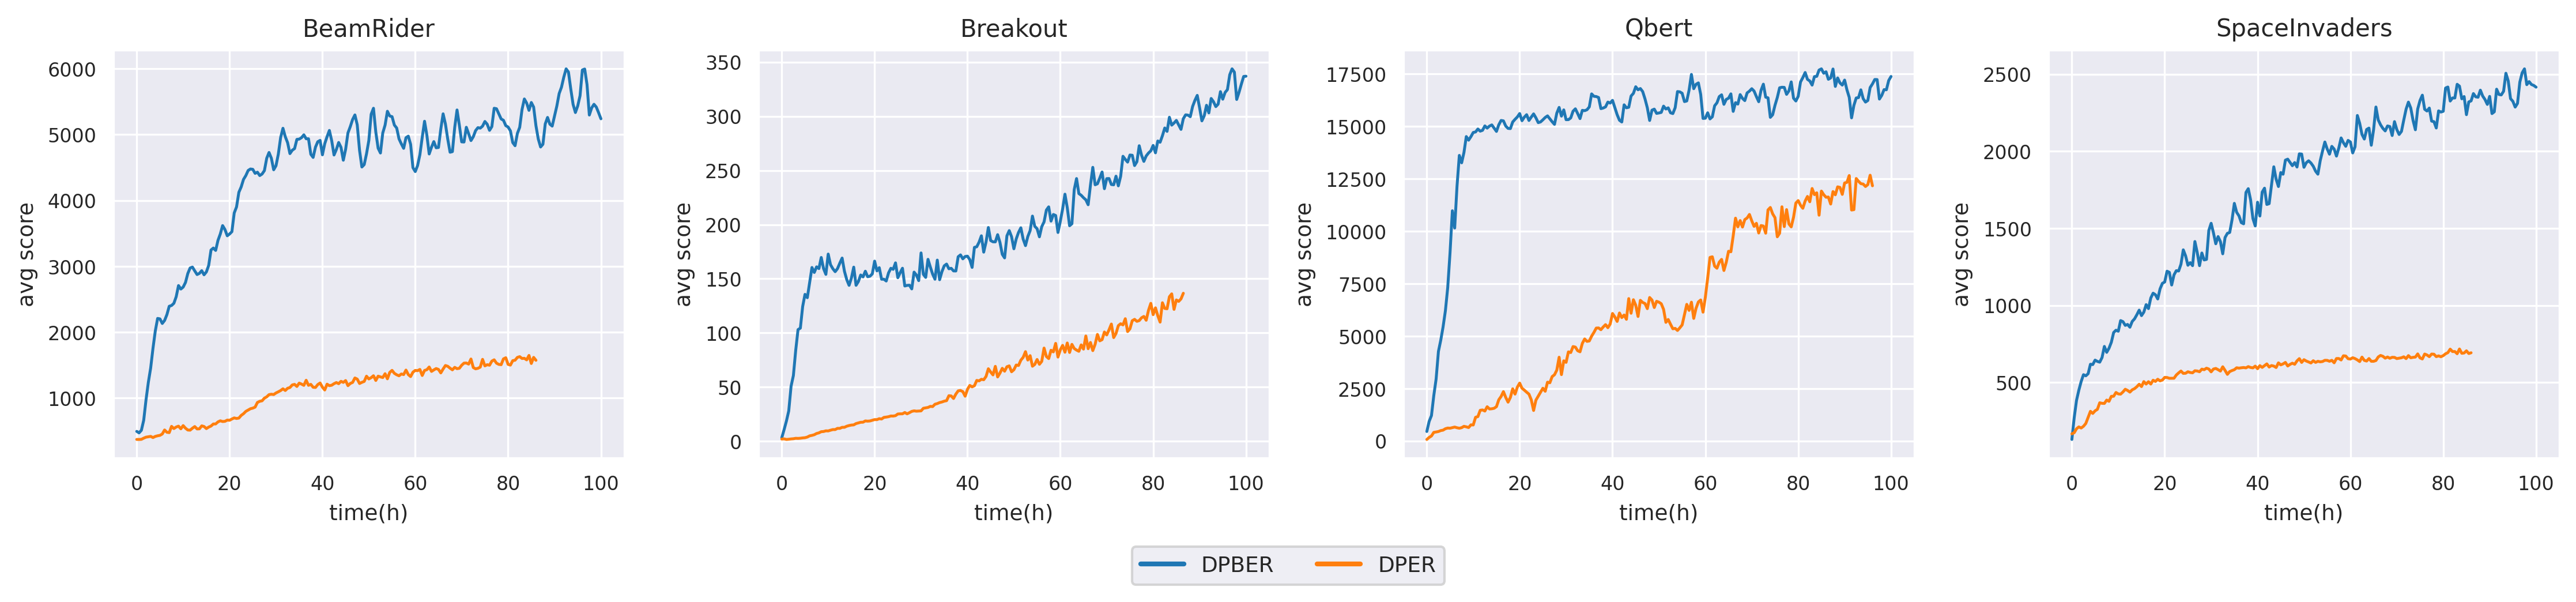

In [33]:
data_df = pd.read_csv(data_path)
data_df = data_df[data_df["env"].isin(["BeamRider", "Breakout", "Qbert", "SpaceInvaders"])]
data_df = data_df[data_df["size"].isin([1, 32])]
# Filter the environments
data_df["time(h)"] = data_df["time_total_s"] / 3600
sampler = {env: data_df[data_df['env'] == env] for env in data_df['env'].unique()}
window_size = 0.25

def compute_rolling_mean(data, window_size=0.5):
    data["time_group"] = (data["time(h)"] // window_size) * window_size
    smoothed_data = data.groupby(["time_group", "buffer"])["episode_reward_mean"].mean().reset_index()
    return smoothed_data

smoothed_sampler = {env: compute_rolling_mean(data) for env, data in sampler.items()}

# Custom palette for the buffers
buffer_palette = {
    'DPBER': sns.color_palette("tab10")[0],
    'DPER': sns.color_palette("tab10")[1]
}

# Create a 6x4 grid for the plots
fig, axes = plt.subplots(1, 4, figsize=(15, 3), dpi=300)
axes = axes.reshape(-1)

# Calculate the rolling mean for each environment and then plot
for ax_n, env in enumerate(data_df['env'].unique()):
    data_env = data_df[data_df['env'] == env]
    smoothed_data_env = compute_rolling_mean(data_env)
    
    ax = sns.lineplot(x="time_group", y="episode_reward_mean", hue="buffer", data=smoothed_data_env, ax=axes[ax_n], palette=buffer_palette, linewidth=1.2)
    ax.set_title(env, fontsize=10)
    ax.set_xlabel("time(h)", fontsize=9)
    ax.set_ylabel("avg score", fontsize=9)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    # Remove the legend from the subplot
    ax.get_legend().remove()

# Hide any unused subplots
for ax_n in range(len(data_df['env'].unique()), len(axes)):
    axes[ax_n].axis('off')

# Create a fixed set of legend labels and their corresponding lines
fixed_legend_labels = ['DPBER', 'DPER']
fixed_legend_lines = [plt.Line2D([0], [0], color=buffer_palette[label], lw=2) for label in fixed_legend_labels]
fig.legend(fixed_legend_lines, fixed_legend_labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=len(fixed_legend_labels), fontsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, bottom=0.1)
plt.show()

/tmp/ipykernel_19397/688990681.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = (data["num_env_steps_sampled"] // window_size) * window_size
/tmp/ipykernel_19397/688990681.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = data["time_group"] * 4
/tmp/ipykernel_19397/688990681.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

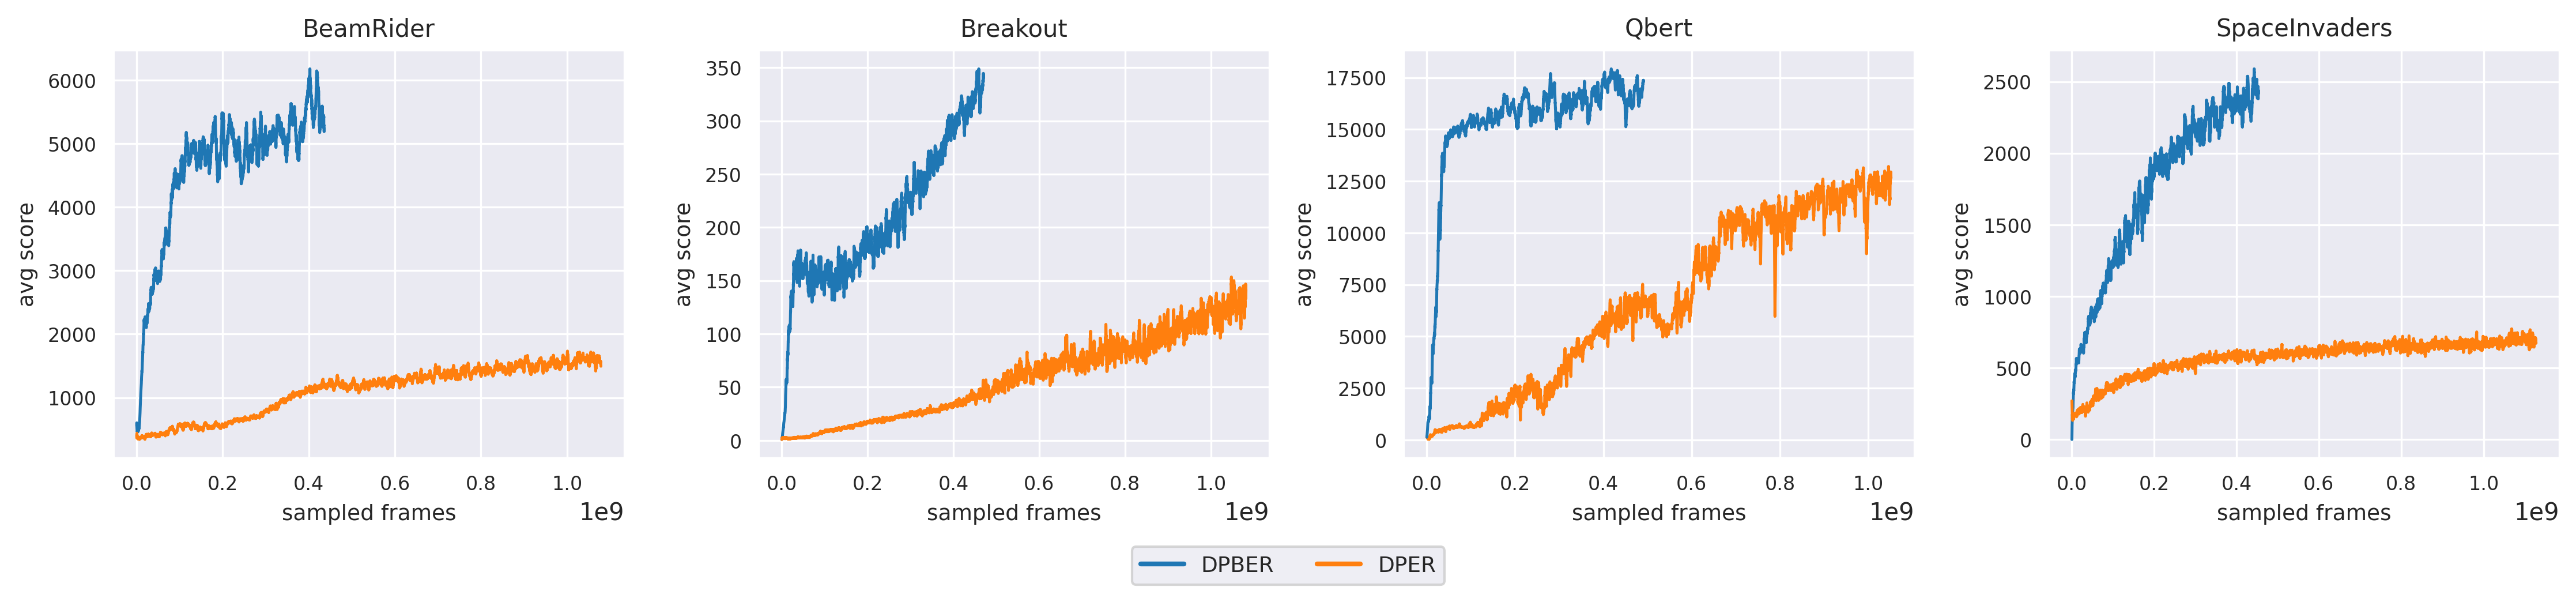

In [34]:
data_df = pd.read_csv(data_path)
data_df = data_df[data_df["env"].isin(["BeamRider", "Breakout", "Qbert", "SpaceInvaders"])]
data_df = data_df[data_df["size"].isin([1, 32])]
# Filter the environments
data_df["time(h)"] = data_df["time_total_s"] / 3600
sampler = {env: data_df[data_df['env'] == env] for env in data_df['env'].unique()}
window_size = 12500

def compute_rolling_mean(data, window_size=0.5):
    data["time_group"] = (data["num_env_steps_sampled"] // window_size) * window_size
    data["time_group"] = data["time_group"] * 4
    smoothed_data = data.groupby(["time_group", "buffer"])[["episode_reward_mean"]].mean().reset_index()
    return smoothed_data

smoothed_sampler = {env: compute_rolling_mean(data) for env, data in sampler.items()}

# Custom palette for the buffers
buffer_palette = {
    'DPBER': sns.color_palette("tab10")[0],
    'DPER': sns.color_palette("tab10")[1]
}

# Create a 6x4 grid for the plots
fig, axes = plt.subplots(1, 4, figsize=(15, 3), dpi=300)
axes = axes.reshape(-1)

# Calculate the rolling mean for each environment and then plot
for ax_n, env in enumerate(data_df['env'].unique()):
    data_env = data_df[data_df['env'] == env]
    smoothed_data_env = compute_rolling_mean(data_env)
    
    ax = sns.lineplot(x="time_group", y="episode_reward_mean", hue="buffer", data=smoothed_data_env, ax=axes[ax_n], palette=buffer_palette, linewidth=1.2)
    ax.set_title(env, fontsize=10)
    ax.set_xlabel("sampled frames", fontsize=9)
    ax.set_ylabel("avg score", fontsize=9)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    # Remove the legend from the subplot
    ax.get_legend().remove()

# Hide any unused subplots
for ax_n in range(len(data_df['env'].unique()), len(axes)):
    axes[ax_n].axis('off')

# Create a fixed set of legend labels and their corresponding lines
fixed_legend_labels = ['DPBER', 'DPER']
fixed_legend_lines = [plt.Line2D([0], [0], color=buffer_palette[label], lw=2) for label in fixed_legend_labels]
fig.legend(fixed_legend_lines, fixed_legend_labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=len(fixed_legend_labels), fontsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, bottom=0.1)
plt.show()

/tmp/ipykernel_19397/679692103.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = (data["num_env_steps_trained"] // window_size) * window_size
/tmp/ipykernel_19397/679692103.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = data["time_group"] * 4
/tmp/ipykernel_19397/679692103.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

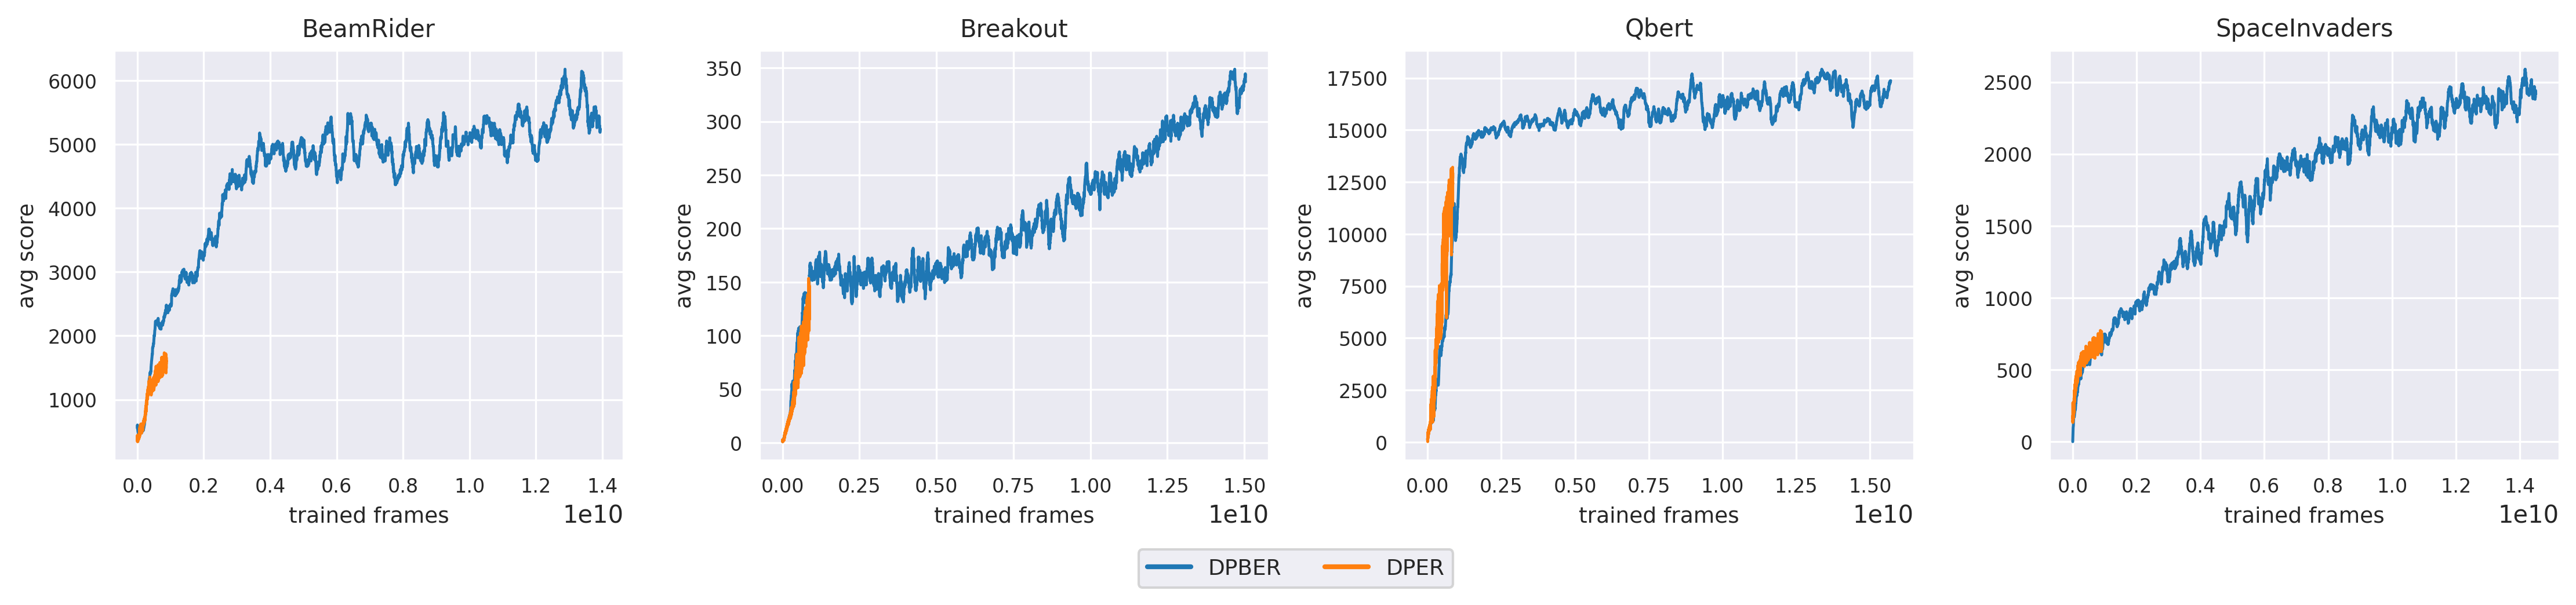

In [35]:
data_df = pd.read_csv(data_path)
data_df = data_df[data_df["env"].isin(["BeamRider", "Breakout", "Qbert", "SpaceInvaders"])]
data_df = data_df[data_df["size"].isin([1, 32])]
# Filter the environments
data_df["time(h)"] = data_df["time_total_s"] / 3600
sampler = {env: data_df[data_df['env'] == env] for env in data_df['env'].unique()}
window_size = 12500

def compute_rolling_mean(data, window_size=0.5):
    data["time_group"] = (data["num_env_steps_trained"] // window_size) * window_size
    data["time_group"] = data["time_group"] * 4
    smoothed_data = data.groupby(["time_group", "buffer"])[["episode_reward_mean"]].mean().reset_index()
    return smoothed_data

smoothed_sampler = {env: compute_rolling_mean(data) for env, data in sampler.items()}

# Custom palette for the buffers
buffer_palette = {
    'DPBER': sns.color_palette("tab10")[0],
    'DPER': sns.color_palette("tab10")[1]
}

# Create a 6x4 grid for the plots
fig, axes = plt.subplots(1, 4, figsize=(15, 3), dpi=300)
axes = axes.reshape(-1)

# Calculate the rolling mean for each environment and then plot
for ax_n, env in enumerate(data_df['env'].unique()):
    data_env = data_df[data_df['env'] == env]
    smoothed_data_env = compute_rolling_mean(data_env)
    
    ax = sns.lineplot(x="time_group", y="episode_reward_mean", hue="buffer", data=smoothed_data_env, ax=axes[ax_n], palette=buffer_palette, linewidth=1.2)
    ax.set_title(env, fontsize=10)
    ax.set_xlabel("trained frames", fontsize=9)
    ax.set_ylabel("avg score", fontsize=9)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    # Remove the legend from the subplot
    ax.get_legend().remove()

# Hide any unused subplots
for ax_n in range(len(data_df['env'].unique()), len(axes)):
    axes[ax_n].axis('off')

# Create a fixed set of legend labels and their corresponding lines
fixed_legend_labels = ['DPBER', 'DPER']
fixed_legend_lines = [plt.Line2D([0], [0], color=buffer_palette[label], lw=2) for label in fixed_legend_labels]
fig.legend(fixed_legend_lines, fixed_legend_labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=len(fixed_legend_labels), fontsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, bottom=0.1)
plt.show()

/tmp/ipykernel_19397/2474938335.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time(h)"] = data["time_total_s"] / 3600
/tmp/ipykernel_19397/2474938335.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = (data["time(h)"] // window_size) * window_size
/tmp/ipykernel_19397/2474938335.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

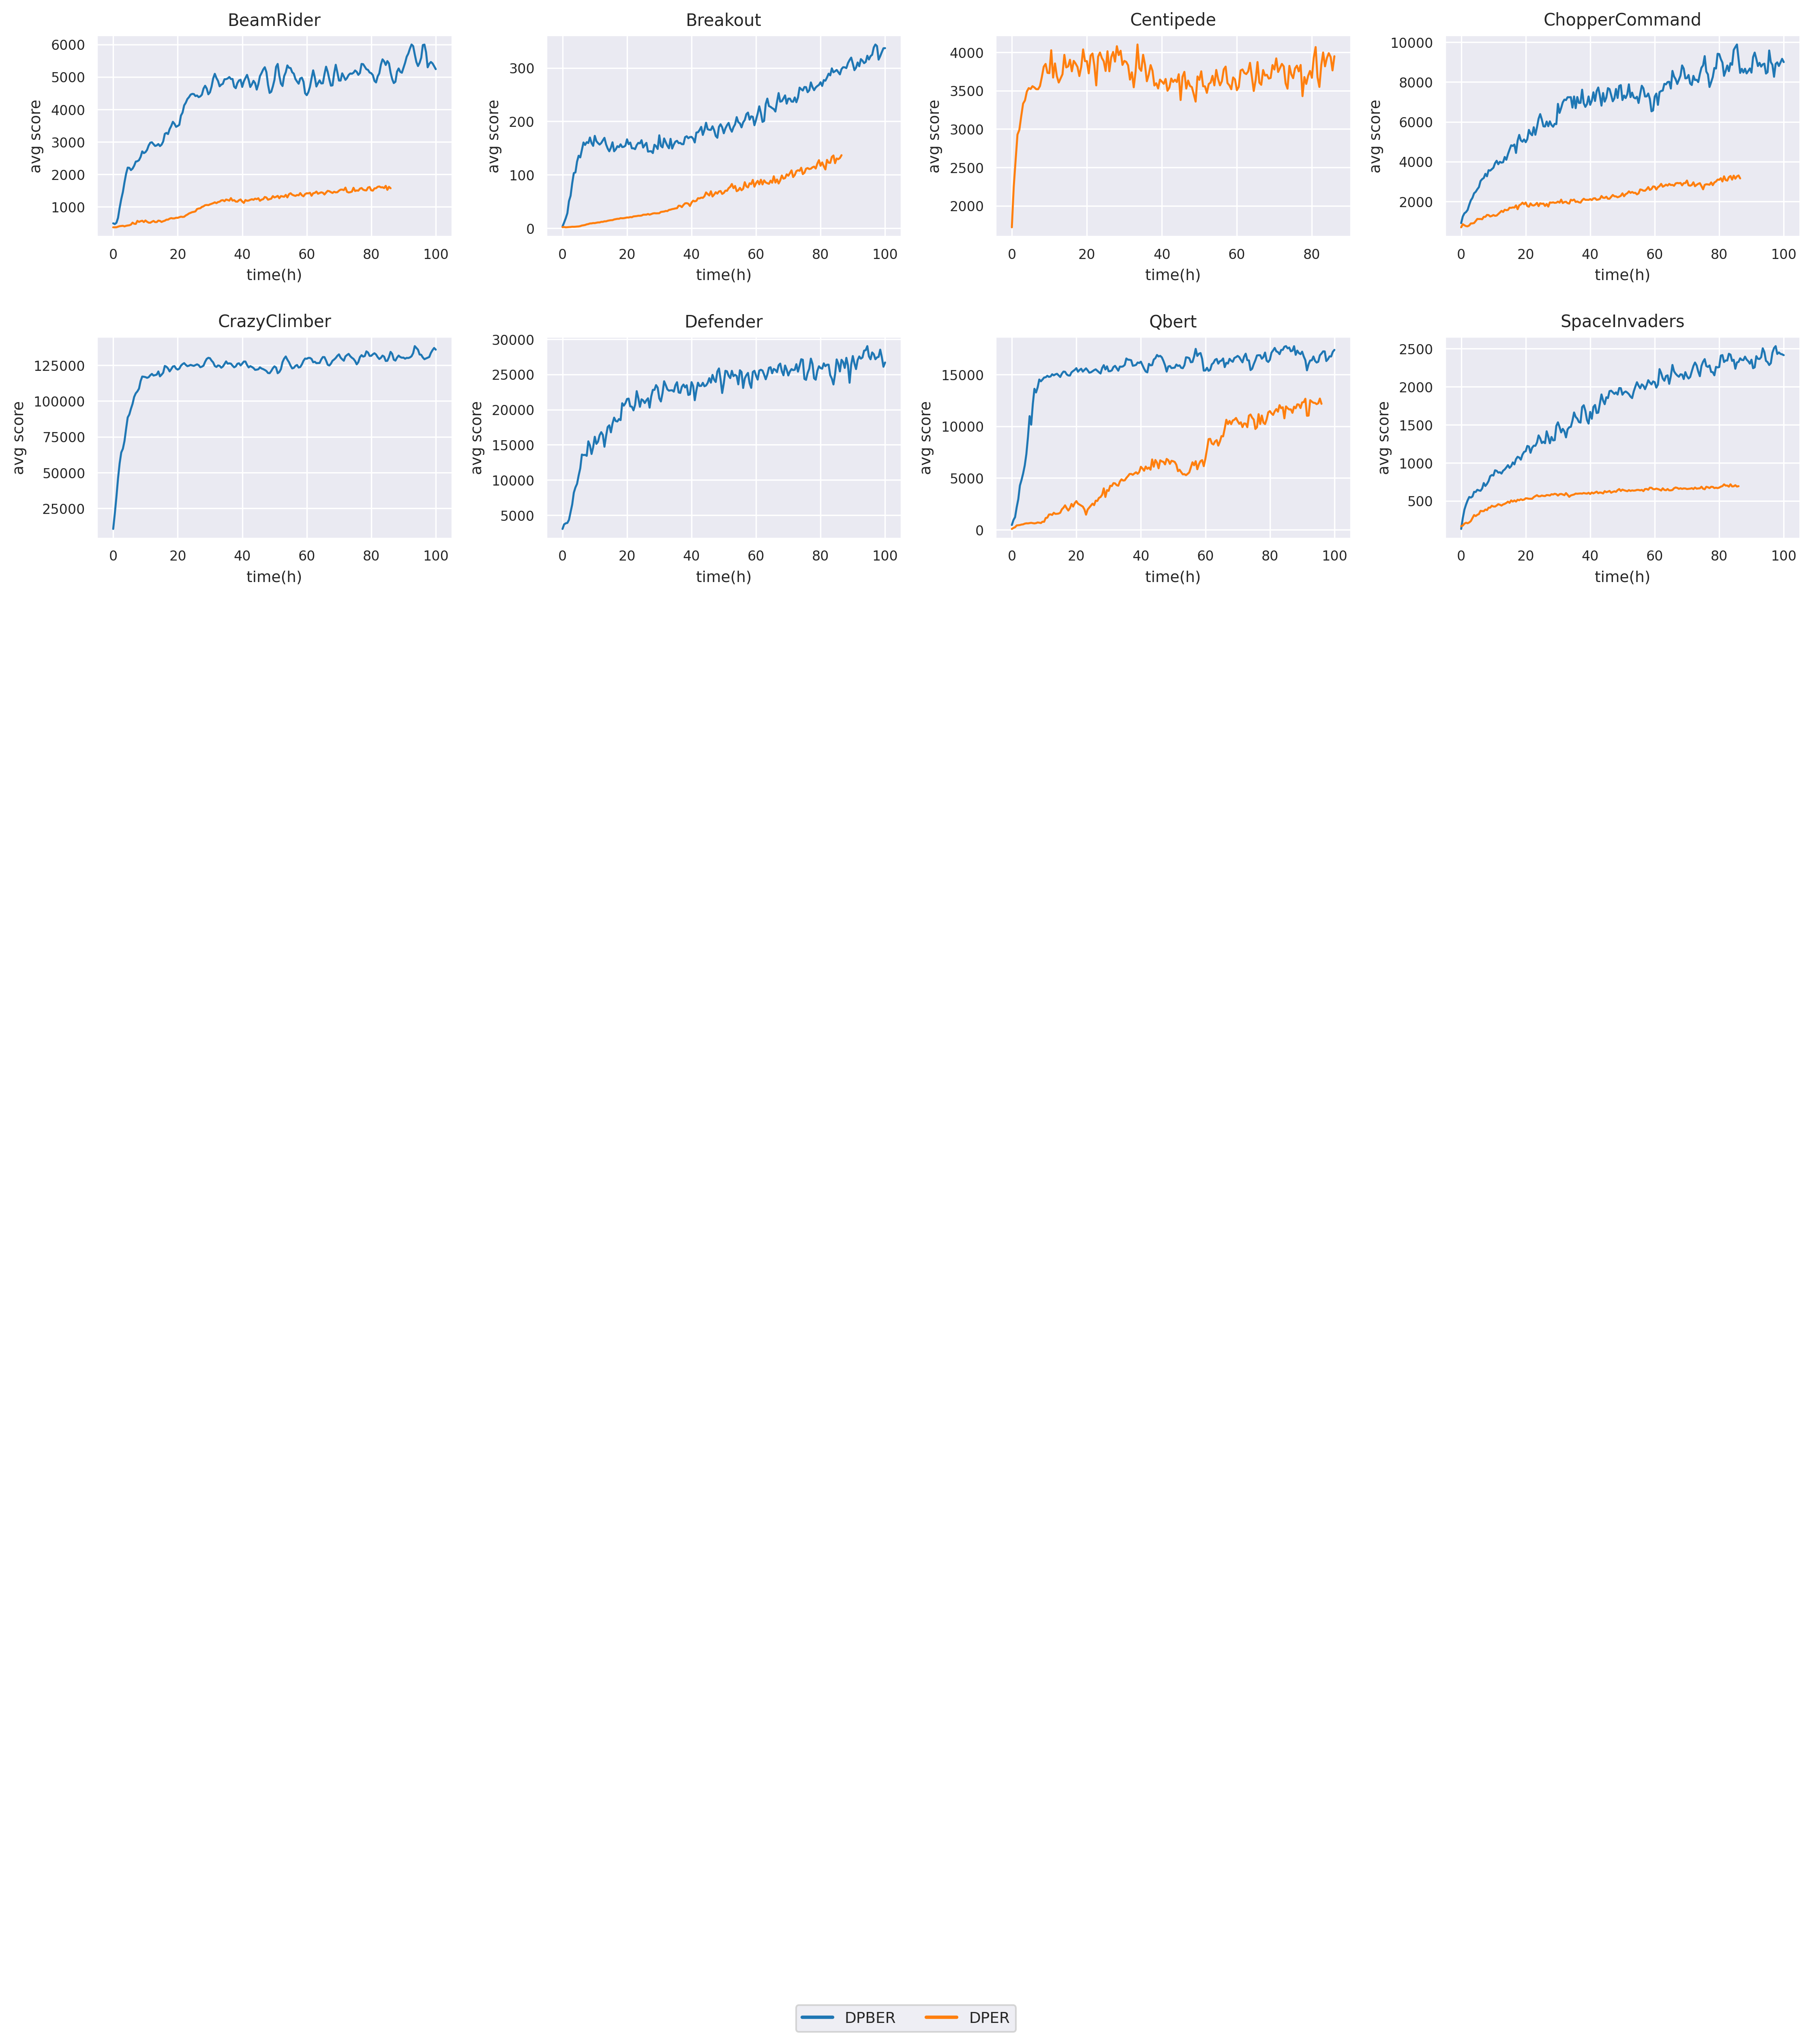

In [22]:
data_df = pd.read_csv(data_path)
data_df = data_df[data_df["size"].isin([1, 32])]
# Filter the environments
data_df["time(h)"] = data_df["time_total_s"] / 3600
sampler = {env: data_df[data_df['env'] == env] for env in data_df['env'].unique()}
window_size = 0.25

def compute_rolling_mean(data, window_size=0.5):
    data["time_group"] = (data["time(h)"] // window_size) * window_size
    smoothed_data = data.groupby(["time_group", "buffer"])["episode_reward_mean"].mean().reset_index()
    return smoothed_data

smoothed_sampler = {env: compute_rolling_mean(data) for env, data in sampler.items()}

# Custom palette for the buffers
buffer_palette = {
    'DPBER': sns.color_palette("tab10")[0],
    'DPER': sns.color_palette("tab10")[1]
}

# Create a 6x4 grid for the plots
fig, axes = plt.subplots(6, 4, figsize=(15, 16), dpi=300)
axes = axes.reshape(-1)

# Calculate the rolling mean for each environment and then plot
for ax_n, env in enumerate(data_df['env'].unique()):
    data_env = data_df[data_df['env'] == env]
    smoothed_data_env = compute_rolling_mean(data_env)
    
    ax = sns.lineplot(x="time_group", y="episode_reward_mean", hue="buffer", data=smoothed_data_env, ax=axes[ax_n], palette=buffer_palette, linewidth=1.2)
    ax.set_title(env, fontsize=10)
    ax.set_xlabel("time(h)", fontsize=9)
    ax.set_ylabel("avg score", fontsize=9)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    # Remove the legend from the subplot
    ax.get_legend().remove()

# Hide any unused subplots
for ax_n in range(len(data_df['env'].unique()), 24):
    axes[ax_n].axis('off')

# Create a fixed set of legend labels and their corresponding lines
fixed_legend_labels = ['DPBER', 'DPER']
fixed_legend_lines = [plt.Line2D([0], [0], color=buffer_palette[label], lw=2) for label in fixed_legend_labels]
fig.legend(fixed_legend_lines, fixed_legend_labels, loc="upper center", bbox_to_anchor=(0.5, -0.03), ncol=len(fixed_legend_labels), fontsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, bottom=0.1)
plt.show()

/tmp/ipykernel_19397/4134119742.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = (data["num_env_steps_sampled"] // window_size) * window_size
/tmp/ipykernel_19397/4134119742.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = data["time_group"] * 4
/tmp/ipykernel_19397/4134119742.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

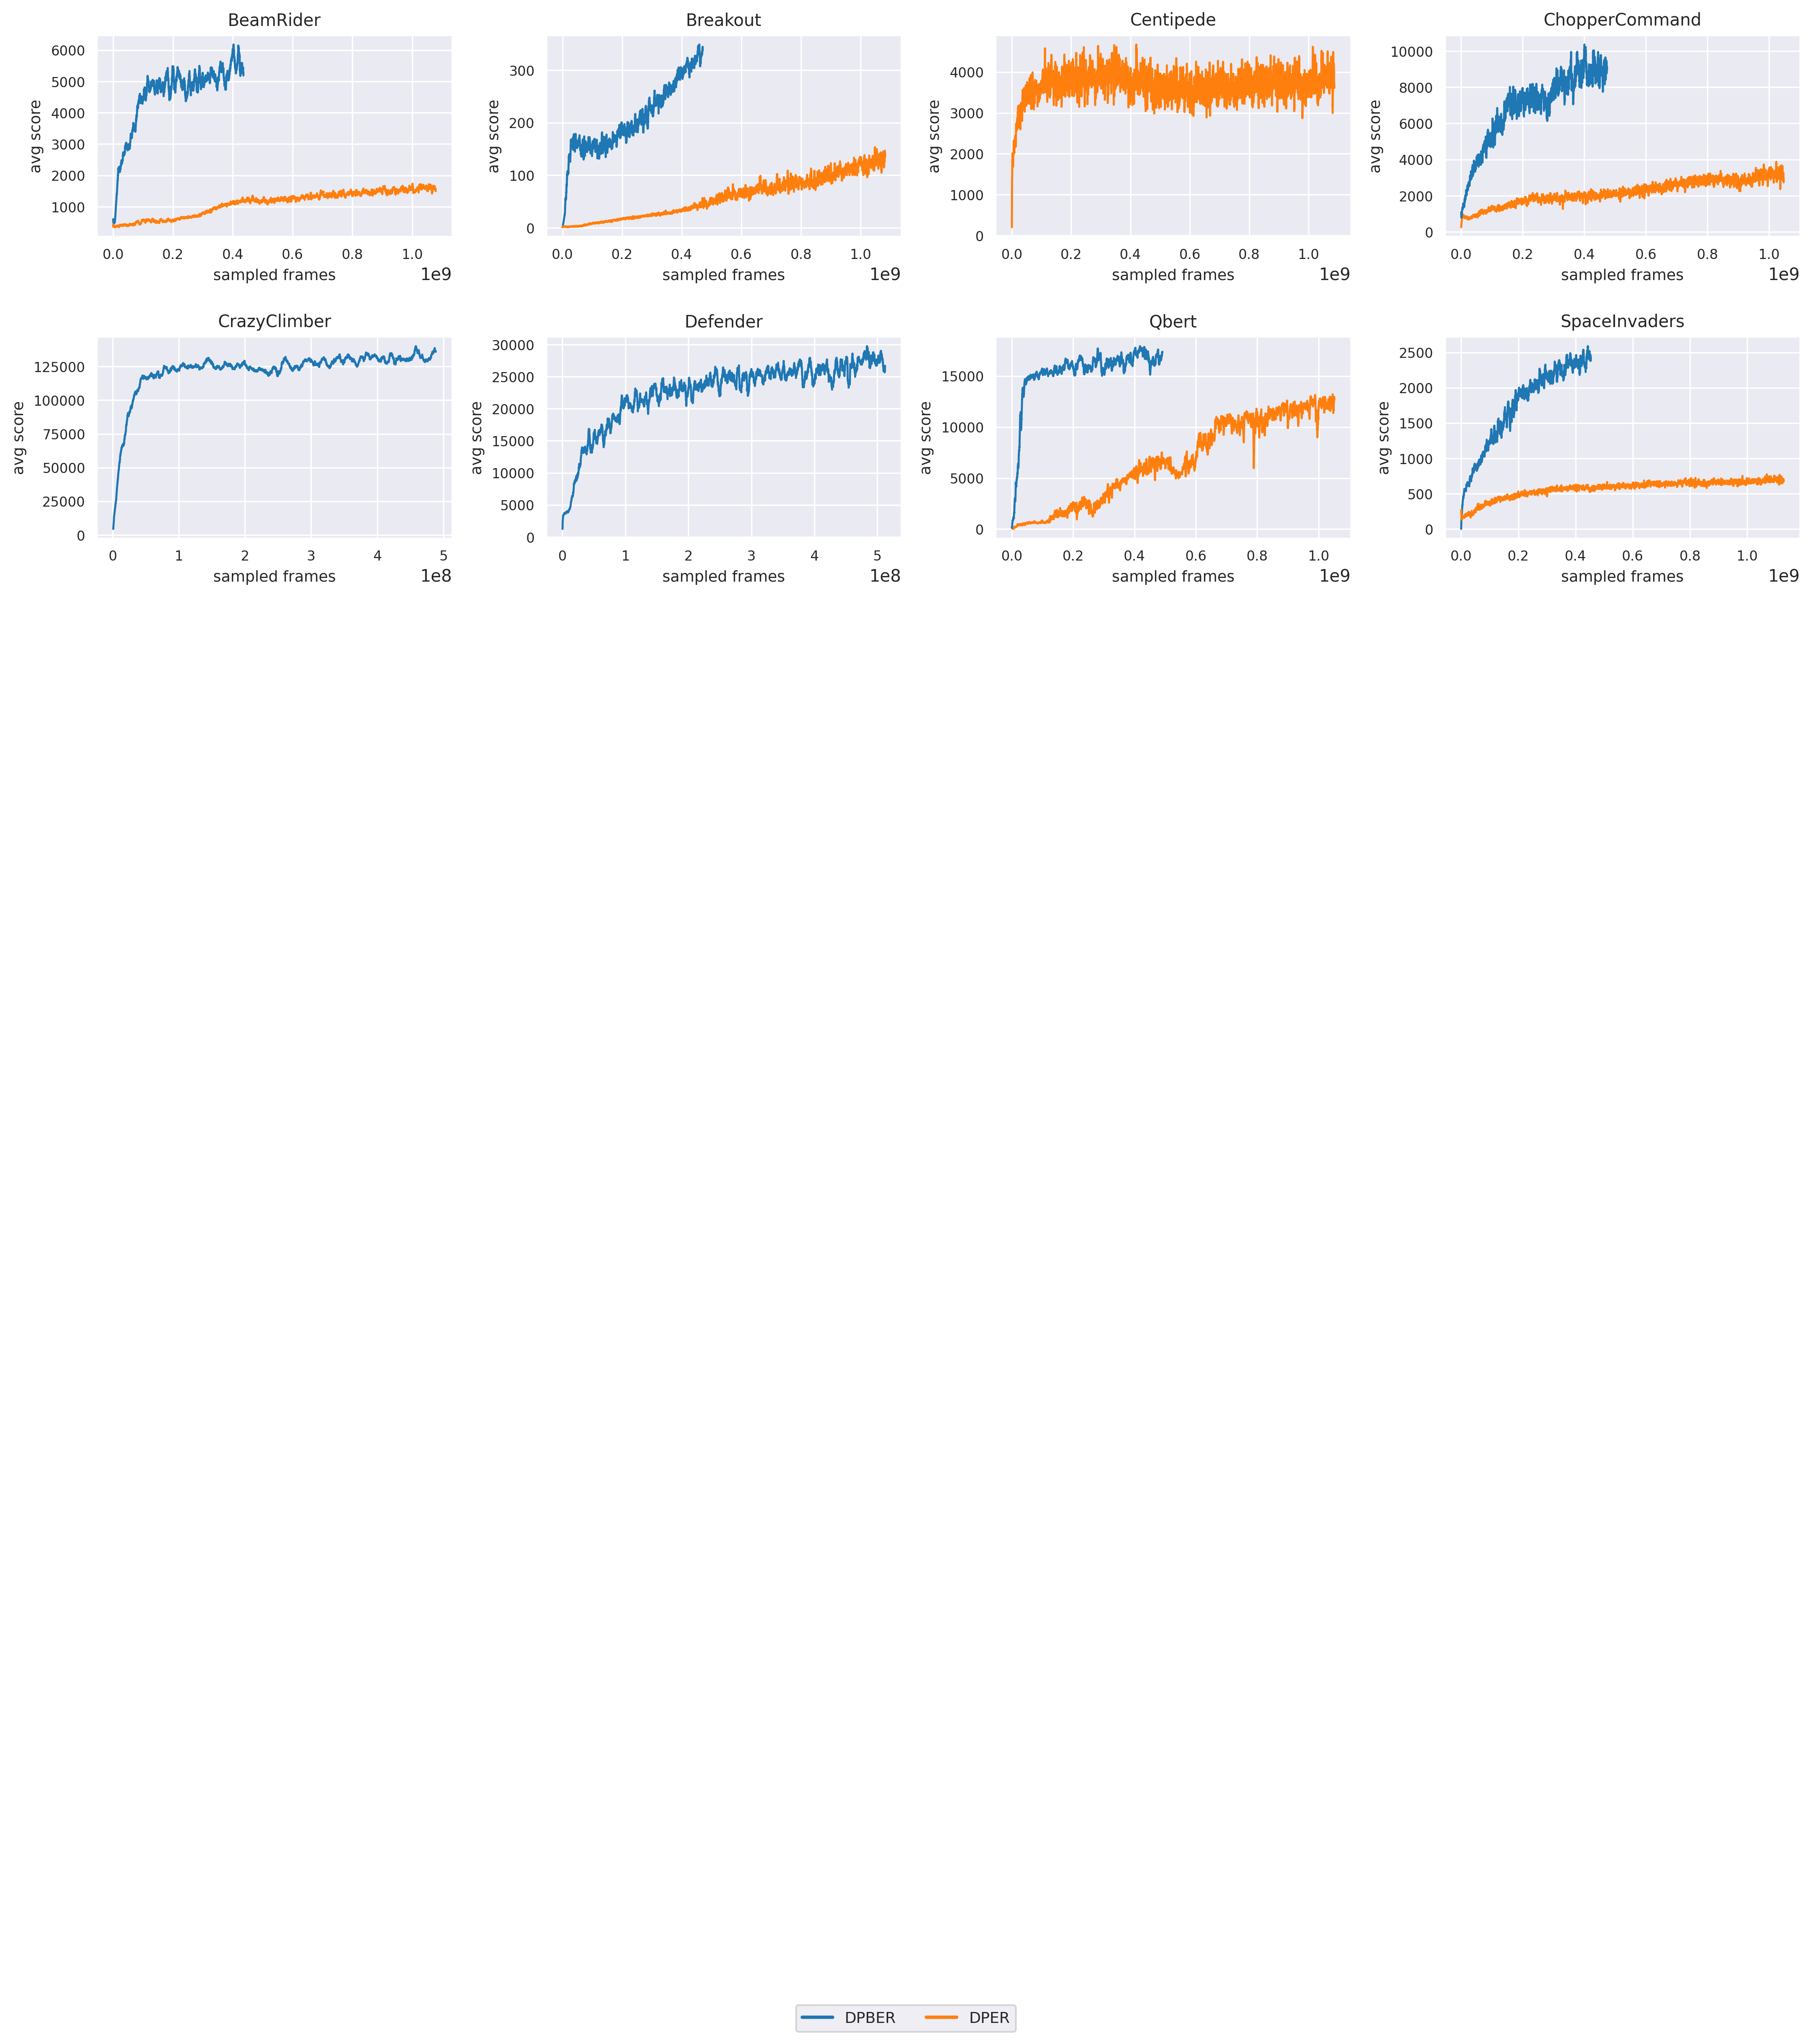

In [25]:
data_df = pd.read_csv(data_path)
data_df = data_df[data_df["size"].isin([1, 32])]
# Filter the environments
data_df["time(h)"] = data_df["time_total_s"] / 3600
sampler = {env: data_df[data_df['env'] == env] for env in data_df['env'].unique()}
window_size = 12500

def compute_rolling_mean(data, window_size=0.5):
    data["time_group"] = (data["num_env_steps_sampled"] // window_size) * window_size
    data["time_group"] = data["time_group"] * 4
    smoothed_data = data.groupby(["time_group", "buffer"])[["episode_reward_mean"]].mean().reset_index()
    return smoothed_data

smoothed_sampler = {env: compute_rolling_mean(data) for env, data in sampler.items()}

# Custom palette for the buffers
buffer_palette = {
    'DPBER': sns.color_palette("tab10")[0],
    'DPER': sns.color_palette("tab10")[1]
}

# Create a 6x4 grid for the plots
fig, axes = plt.subplots(6, 4, figsize=(15, 16), dpi=300)
axes = axes.reshape(-1)

# Calculate the rolling mean for each environment and then plot
for ax_n, env in enumerate(data_df['env'].unique()):
    data_env = data_df[data_df['env'] == env]
    smoothed_data_env = compute_rolling_mean(data_env)
    
    ax = sns.lineplot(x="time_group", y="episode_reward_mean", hue="buffer", data=smoothed_data_env, ax=axes[ax_n], palette=buffer_palette, linewidth=1.2)
    ax.set_title(env, fontsize=10)
    ax.set_xlabel("sampled frames", fontsize=9)
    ax.set_ylabel("avg score", fontsize=9)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    # Remove the legend from the subplot
    ax.get_legend().remove()

# Hide any unused subplots
for ax_n in range(len(data_df['env'].unique()), 24):
    axes[ax_n].axis('off')

# Create a fixed set of legend labels and their corresponding lines
fixed_legend_labels = ['DPBER', 'DPER']
fixed_legend_lines = [plt.Line2D([0], [0], color=buffer_palette[label], lw=2) for label in fixed_legend_labels]
fig.legend(fixed_legend_lines, fixed_legend_labels, loc="upper center", bbox_to_anchor=(0.5, -0.03), ncol=len(fixed_legend_labels), fontsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, bottom=0.1)
plt.show()

/tmp/ipykernel_19397/832222916.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = (data["num_env_steps_trained"] // window_size) * window_size
/tmp/ipykernel_19397/832222916.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = data["time_group"] * 4
/tmp/ipykernel_19397/832222916.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

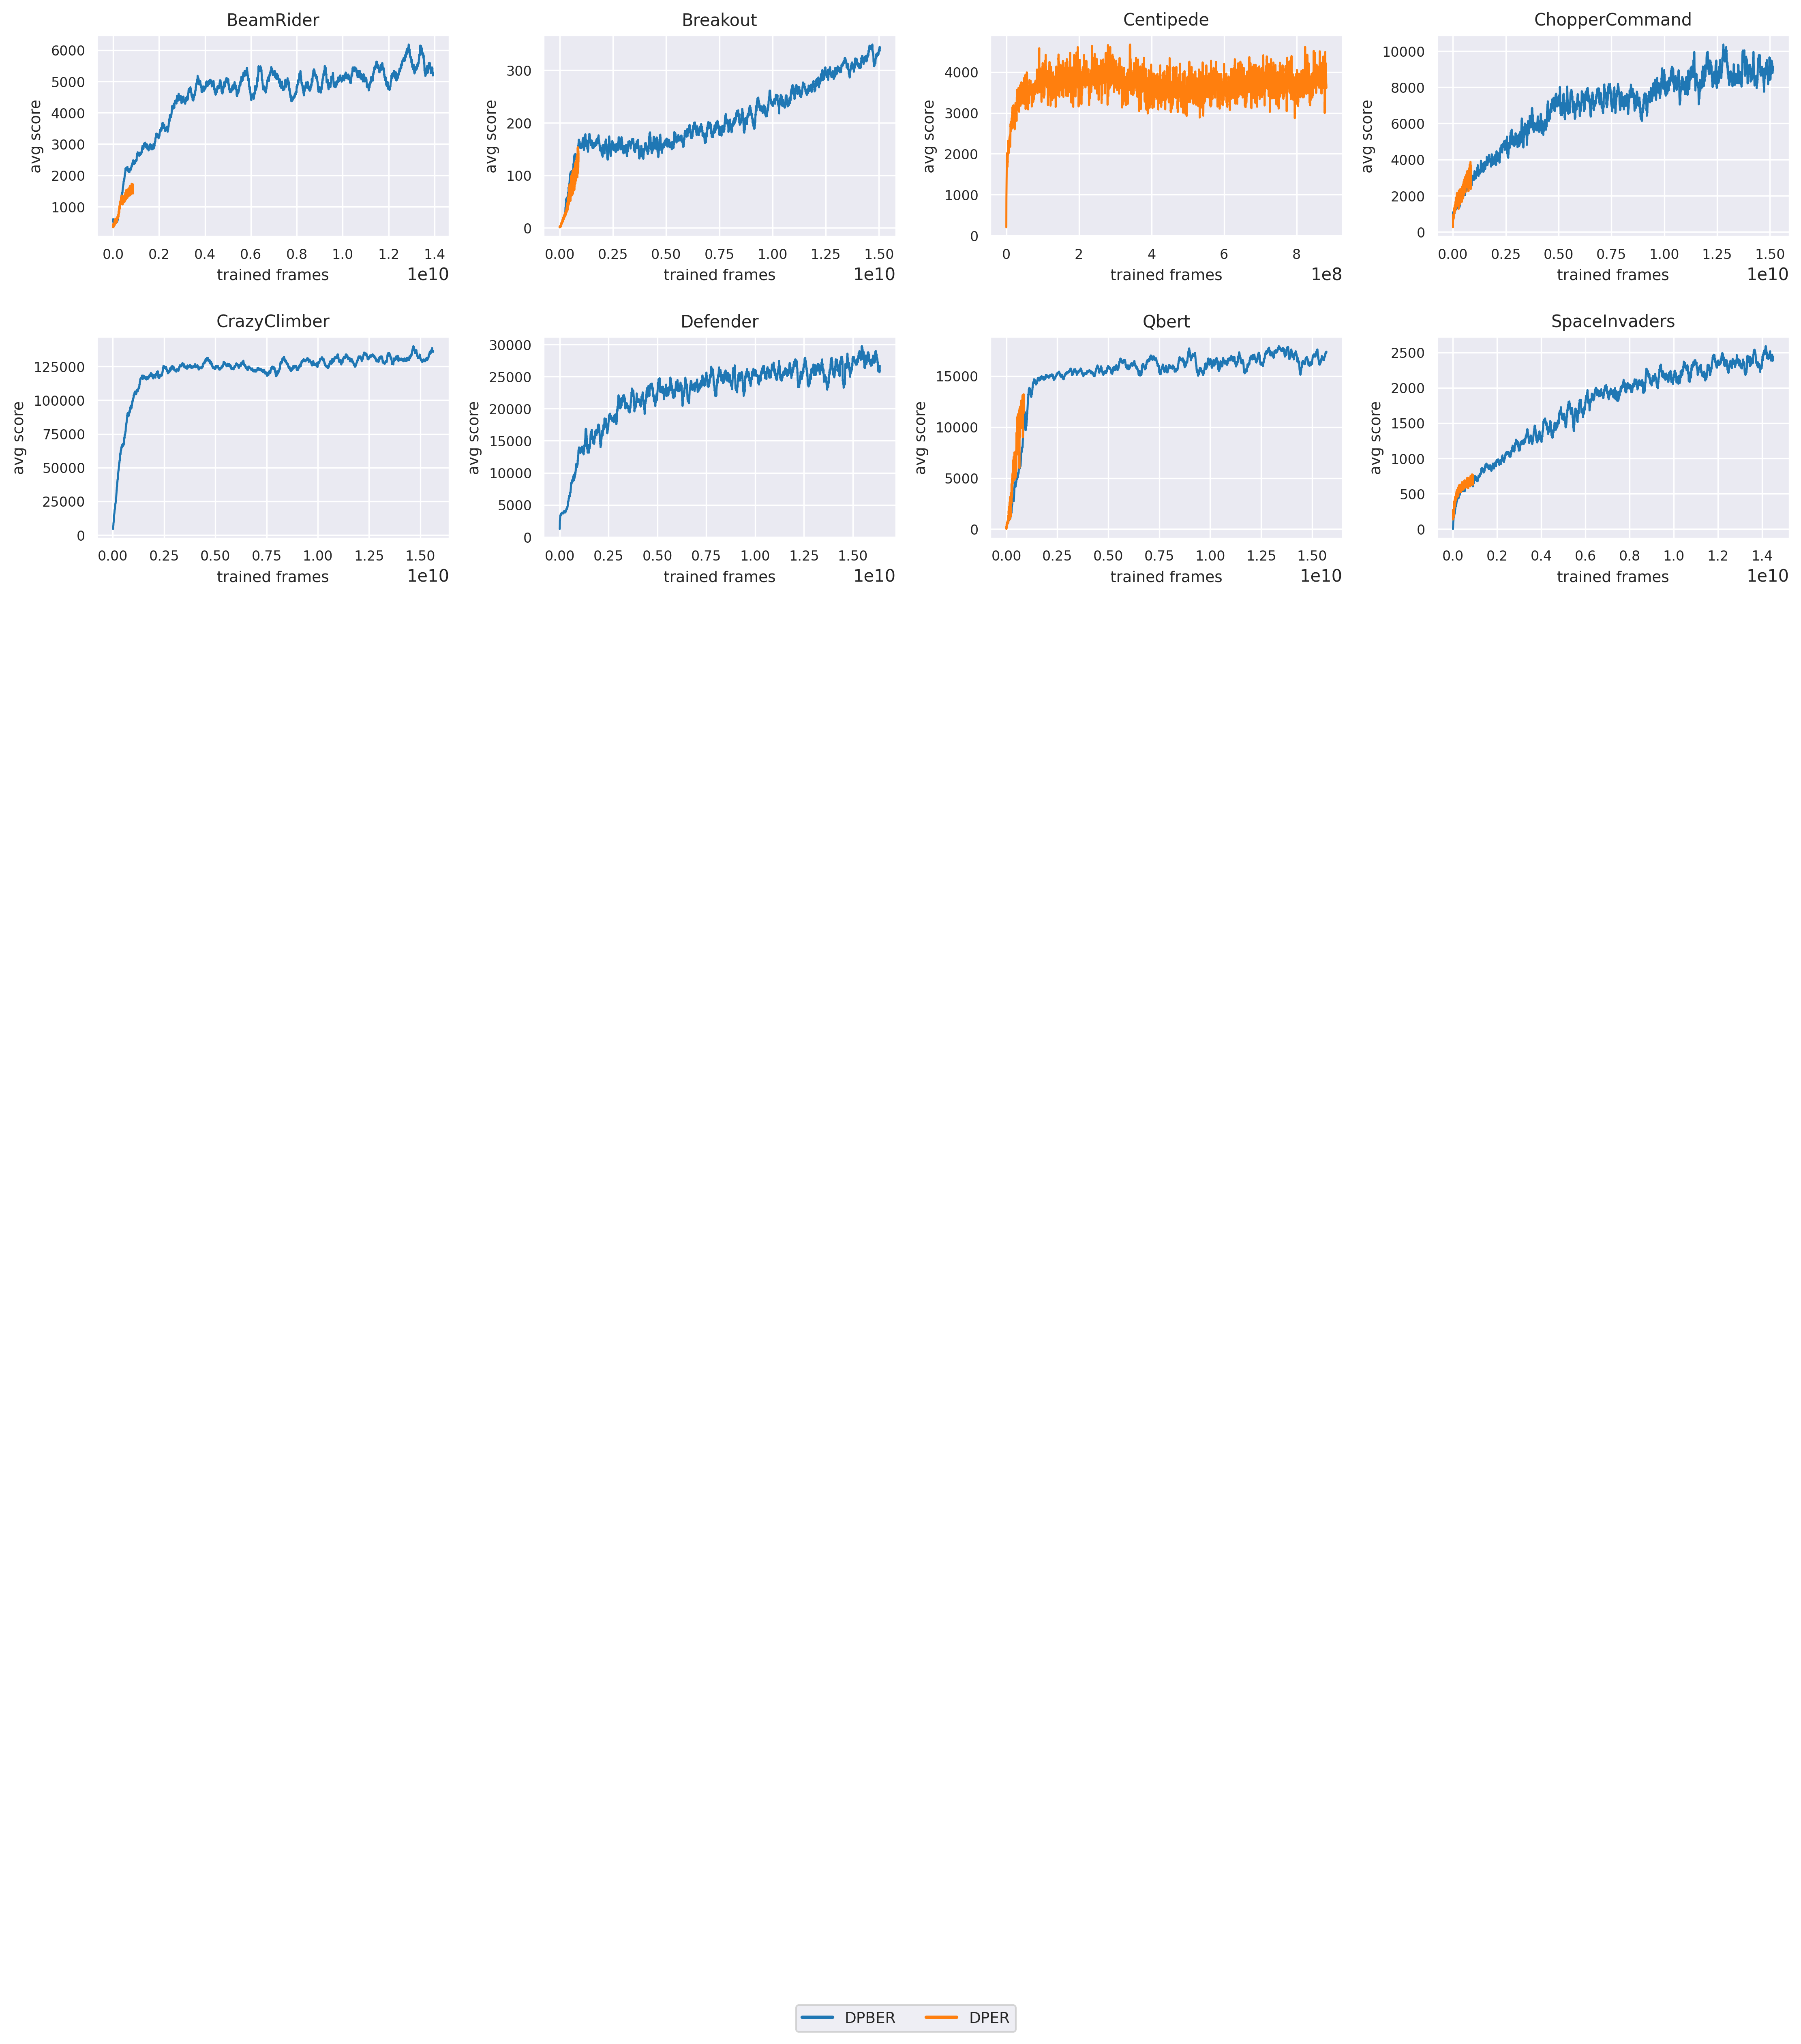

In [26]:
data_df = pd.read_csv(data_path)
data_df = data_df[data_df["size"].isin([1, 32])]
# Filter the environments
data_df["time(h)"] = data_df["time_total_s"] / 3600
sampler = {env: data_df[data_df['env'] == env] for env in data_df['env'].unique()}
window_size = 12500

def compute_rolling_mean(data, window_size=0.5):
    data["time_group"] = (data["num_env_steps_trained"] // window_size) * window_size
    data["time_group"] = data["time_group"] * 4
    smoothed_data = data.groupby(["time_group", "buffer"])[["episode_reward_mean"]].mean().reset_index()
    return smoothed_data

smoothed_sampler = {env: compute_rolling_mean(data) for env, data in sampler.items()}

# Custom palette for the buffers
buffer_palette = {
    'DPBER': sns.color_palette("tab10")[0],
    'DPER': sns.color_palette("tab10")[1]
}

# Create a 6x4 grid for the plots
fig, axes = plt.subplots(6, 4, figsize=(15, 16), dpi=300)
axes = axes.reshape(-1)

# Calculate the rolling mean for each environment and then plot
for ax_n, env in enumerate(data_df['env'].unique()):
    data_env = data_df[data_df['env'] == env]
    smoothed_data_env = compute_rolling_mean(data_env)
    
    ax = sns.lineplot(x="time_group", y="episode_reward_mean", hue="buffer", data=smoothed_data_env, ax=axes[ax_n], palette=buffer_palette, linewidth=1.2)
    ax.set_title(env, fontsize=10)
    ax.set_xlabel("trained frames", fontsize=9)
    ax.set_ylabel("avg score", fontsize=9)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    # Remove the legend from the subplot
    ax.get_legend().remove()

# Hide any unused subplots
for ax_n in range(len(data_df['env'].unique()), 24):
    axes[ax_n].axis('off')

# Create a fixed set of legend labels and their corresponding lines
fixed_legend_labels = ['DPBER', 'DPER']
fixed_legend_lines = [plt.Line2D([0], [0], color=buffer_palette[label], lw=2) for label in fixed_legend_labels]
fig.legend(fixed_legend_lines, fixed_legend_labels, loc="upper center", bbox_to_anchor=(0.5, -0.03), ncol=len(fixed_legend_labels), fontsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, bottom=0.1)
plt.show()

In [10]:
data_df = pd.read_csv(data_path)
data_df = data_df[data_df["size"].isin([1, 32])]
n = 5
window_size_hours = 0.25
data_df["time(h)"] = data_df["time_total_s"] / 3600

# 2. Define helper functions
def apply_offsets_to_data(data):
    recommended_offsets = {
        'Boxing': 20,
        'Pong': 21,
        'FishingDerby': 100,
        'Frostbite': 5,
        'Enduro': 10,
        'Q*bert': 0
    }
    for env, min_reward in data.groupby('env')['episode_reward_mean'].min().items():
        if env not in recommended_offsets and min_reward < 0:
            recommended_offsets[env] = abs(min_reward) + 1
    data['episode_reward_mean'] = data.apply(lambda row: row['episode_reward_mean'] + recommended_offsets.get(row['env'], 0), axis=1)
    return data

def compute_interval_mean_with_env(env_data):
    env_name = env_data['env'].iloc[0]
    bins = list(np.arange(0, env_data["time(h)"].max() + window_size_hours, window_size_hours))
    env_data["time_interval"] = pd.cut(env_data["time(h)"], bins, labels=bins[:-1], right=False)
    numeric_cols = env_data.select_dtypes(include=[np.number]).columns.tolist()
    interval_data = env_data.groupby('time_interval')[numeric_cols].mean().reset_index()
    interval_data['env'] = env_name
    return interval_data

def compute_avg_reward_last_episodes(env_name, data1, data2, n):
    last_rewards1 = data1[data1['env'] == env_name]['episode_reward_mean'].tail(n).values
    last_rewards2 = data2[data2['env'] == env_name]['episode_reward_mean'].tail(n).values
    avg_reward1 = last_rewards1.mean()
    avg_reward2 = last_rewards2.mean()
    return avg_reward1, avg_reward2

def compute_T_save_for_env(env_name, data1, data2):
    rewards1 = data1[data1['env'] == env_name]['episode_reward_mean'].values
    rewards2 = data2[data2['env'] == env_name]['episode_reward_mean'].values
    if len(rewards1) == 0 or len(rewards2) == 0:
        return None
    times1 = data1[data1['env'] == env_name]['time(h)'].values
    times2 = data2[data2['env'] == env_name]['time(h)'].values
    time_diff_ratios = []
    max_reward = max(rewards1.max(), rewards2.max())
    reward_samples = np.linspace(0, max_reward, 51)
    for target_reward in reward_samples:
        time1 = next((times1[i] for i, r in enumerate(rewards1) if r >= target_reward), None)
        time2 = next((times2[i] for i, r in enumerate(rewards2) if r >= target_reward), None)
        if time1 is not None and time2 is not None:
            time_diff_ratio = (time1 - time2) / time1
            time_diff_ratios.append(time_diff_ratio)
    return np.median(time_diff_ratios) if time_diff_ratios else None

# 3. Main data processing and analysis steps
# Sort data by time
data_df_sorted = data_df.sort_values(by=["env", "time(h)"])
# Apply offsets to the data
data_df_sorted = apply_offsets_to_data(data_df_sorted)

# Split sorted data for ER vs. BER and PER vs. PBER
er_data_sorted = data_df_sorted[data_df_sorted['buffer'] == 'DPER']
ber_data_sorted = data_df_sorted[data_df_sorted['buffer'] == 'DPBER']

# Compute interval mean for each buffer type and environment using sorted data
er_interval_data_sorted = pd.concat([compute_interval_mean_with_env(er_data_sorted[er_data_sorted['env'] == env]) for env in er_data_sorted['env'].unique()])
ber_interval_data_sorted = pd.concat([compute_interval_mean_with_env(ber_data_sorted[ber_data_sorted['env'] == env]) for env in ber_data_sorted['env'].unique()])

# Compute metrics for ER vs. BER and PER vs. PBER using sorted data
results_sorted = []
for env in data_df_sorted['env'].unique():
    R_improve_er_ber = (ber_interval_data_sorted[ber_interval_data_sorted['env'] == env]["episode_reward_mean"].median() - er_interval_data_sorted[er_interval_data_sorted['env'] == env]["episode_reward_mean"].median()) / ber_interval_data_sorted[ber_interval_data_sorted['env'] == env]["episode_reward_mean"].median()

    T_save_er_ber = compute_T_save_for_env(env, er_data_sorted, ber_data_sorted)
    
    avg_er_reward, avg_ber_reward = compute_avg_reward_last_episodes(env, er_data_sorted, ber_data_sorted, n)
    
    improvement_percentage_er_ber = ((avg_ber_reward - avg_er_reward) / avg_er_reward)  if avg_er_reward != 0 else np.nan
    
    results_sorted.append({
        'Environment': env,
        'R_improve_DPER_DPBER': R_improve_er_ber,
        'T_save_DPER_DPBER': T_save_er_ber,
        'R_last_DPER_DPBER': improvement_percentage_er_ber,
    })

# Convert results to a DataFrame and compute mean values
result_df_sorted = pd.DataFrame(results_sorted).set_index('Environment')

# 4. Calculate the average rates for num_env_steps_sampled and num_env_steps_trained per env and buffer
data_df['sampled/s'] = data_df['num_env_steps_sampled'] / data_df['time_total_s']
data_df['trained/s'] = data_df['num_env_steps_trained'] / data_df['time_total_s']

# Group by env and buffer and calculate mean rates
grouped_rates = data_df.groupby(['env', 'buffer'])[['sampled/s', 'trained/s']].mean().reset_index()

# Separate the rates for DPER and DPBER
dper_rates = grouped_rates[grouped_rates['buffer'] == 'DPER'].set_index('env')[['sampled/s', 'trained/s']]
dpber_rates = grouped_rates[grouped_rates['buffer'] == 'DPBER'].set_index('env')[['sampled/s', 'trained/s']]

# Calculate the ratio of DPBER to DPER for sampled and trained rates
rate_ratios = dpber_rates / dper_rates
rate_ratios = rate_ratios.reset_index()

# Append rate ratios to result_df_sorted
result_df_combined = result_df_sorted.merge(rate_ratios, left_index=True, right_on='env').set_index('env')
result_df_combined

/tmp/ipykernel_19397/940450844.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data["time_interval"] = pd.cut(env_data["time(h)"], bins, labels=bins[:-1], right=False)
/tmp/ipykernel_19397/940450844.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data["time_interval"] = pd.cut(env_data["time(h)"], bins, labels=bins[:-1], right=False)
/tmp/ipykernel_19397/940450844.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,R_improve_DPER_DPBER,T_save_DPER_DPBER,R_last_DPER_DPBER,sampled/s,trained/s
env,,,,,
BeamRider,0.748164,NaN,2.441475,0.314312,12.375385
Breakout,0.697940,0.934748,1.503206,0.366959,14.461995
Centipede,NaN,NaN,NaN,NaN,NaN
ChopperCommand,0.706291,0.894913,2.143533,0.391122,15.389980
CrazyClimber,NaN,NaN,NaN,NaN,NaN
Defender,NaN,NaN,NaN,NaN,NaN
Qbert,0.620945,0.910297,0.358096,0.456417,17.941531
SpaceInvaders,0.682590,0.808614,2.595387,0.331863,13.087334


In [17]:
result_df_combined.loc[["BeamRider", "Breakout", "Qbert", "SpaceInvaders"]].mean()

R_improve_DPER_DPBER     0.687410
T_save_DPER_DPBER        0.884553
R_last_DPER_DPBER        1.724541
sampled/s                0.367388
trained/s               14.466561
dtype: float64

In [11]:
def remove_outliers_and_compute_mean(column_data):
    # Compute IQR
    Q1 = column_data.quantile(0.25)
    Q3 = column_data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Filter out outliers
    filtered_data = column_data[~((column_data < (Q1 - IQR)) | (column_data > (Q3 + IQR)))]
    
    # Compute mean
    return filtered_data.mean()

# Apply the function on each column
filtered_means = result_df_combined.apply(remove_outliers_and_compute_mean)
filtered_means.name = "Normalized"
filtered_means_df = pd.DataFrame(filtered_means).T
filtered_means_df = pd.concat([result_df_combined, filtered_means_df])
filtered_means_df

,R_improve_DPER_DPBER,T_save_DPER_DPBER,R_last_DPER_DPBER,sampled/s,trained/s
BeamRider,0.748164,NaN,2.441475,0.314312,12.375385
Breakout,0.697940,0.934748,1.503206,0.366959,14.461995
Centipede,NaN,NaN,NaN,NaN,NaN
ChopperCommand,0.706291,0.894913,2.143533,0.391122,15.389980
CrazyClimber,NaN,NaN,NaN,NaN,NaN
Defender,NaN,NaN,NaN,NaN,NaN
Qbert,0.620945,0.910297,0.358096,0.456417,17.941531
SpaceInvaders,0.682590,0.808614,2.595387,0.331863,13.087334
Normalized,0.695607,0.913320,2.170900,0.351064,13.828673


In [12]:
filtered_means.to_dict()

{'R_improve_DPER_DPBER': 0.6956070283283505,
 'T_save_DPER_DPBER': 0.9133195211180163,
 'R_last_DPER_DPBER': 2.1709001833361286,
 'sampled/s': 0.3510642736142048,
 'trained/s': 13.828673288785577}

In [13]:
def generate_refined_latex_table_fixed(df):
    header = "\\begin{tabular}{" + "l" + "c"*df.shape[1] + "}\n\\toprule"
    
    # Headers with formatted names
    column_names = []
    for col in df.columns:
        if "_" in col:
            formatted_name = "$" + col.split("_")[0] + "_{" + col.split("_")[1] + "}$"
        else:
            formatted_name = col
        column_names.append(formatted_name)
    
    rows = [" & \\multicolumn{3}{c}{Metrics} & \\multicolumn{2}{c}{Frames} \\\\ \\cmidrule(lr){2-4} \\cmidrule(lr){5-6}"]
    rows.append(" & ".join([""] + column_names) + " \\\ \midrule")
    
    for index, row in df.iterrows():
        rows.append("{} & {}".format(index, " & ".join(["{:.4f}".format(val) for val in row.values])) + " \\\ ")
    
    footer = "\\bottomrule\n\\end{tabular}"
    return header + "\n" + "\n".join(rows) + "\n" + footer

# Generate the LaTeX table using the fixed function
latex_table_fixed = generate_refined_latex_table_fixed(filtered_means_df)
print(latex_table_fixed)

\begin{tabular}{lccccc}
\toprule
 & \multicolumn{3}{c}{Metrics} & \multicolumn{2}{c}{Frames} \\ \cmidrule(lr){2-4} \cmidrule(lr){5-6}
 & $R_{improve}$ & $T_{save}$ & $R_{last}$ & sampled/s & trained/s \\ \midrule
BeamRider & 0.7482 & nan & 2.4415 & 0.3143 & 12.3754 \\ 
Breakout & 0.6979 & 0.9347 & 1.5032 & 0.3670 & 14.4620 \\ 
Centipede & nan & nan & nan & nan & nan \\ 
ChopperCommand & 0.7063 & 0.8949 & 2.1435 & 0.3911 & 15.3900 \\ 
CrazyClimber & nan & nan & nan & nan & nan \\ 
Defender & nan & nan & nan & nan & nan \\ 
Qbert & 0.6209 & 0.9103 & 0.3581 & 0.4564 & 17.9415 \\ 
SpaceInvaders & 0.6826 & 0.8086 & 2.5954 & 0.3319 & 13.0873 \\ 
Normalized & 0.6956 & 0.9133 & 2.1709 & 0.3511 & 13.8287 \\ 
\bottomrule
\end{tabular}
